<a href="https://colab.research.google.com/github/vincent-grari/DIVERS/blob/main/toyscenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip3 install geojsoncontour

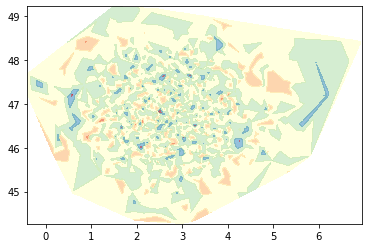

In [87]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

# Setup
temp_mean = 12
temp_std  = 2
debug     = False

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)

# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(2.75,     1.,     2000),
    'latitude':    np.random.normal(46.8,     0.8,     2000),
    })
df['temperature']= np.random.normal(46.7,     0.5,     2000)
# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.temperature.tolist())

# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

# Gaussian filter the grid to make it smoother
sigma = [5, 5]
#z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)

# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=15,
    stroke_width=1,
    fill_opacity=0.5)

# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)

# Plot the data
geomap.save(f'folium_contour_temperature_map.html')